In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import earthaccess
import h5netcdf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyinterp.backends.xarray  # Module that handles the filling of undefined values.
import pyinterp.fill
import seaborn as sns
import xarray as xr
import rioxarray as rxr
from matplotlib.patches import Rectangle
import logging
import xarray as xr
import dask.array as da
from dask_ml.decomposition import PCA
from dask_ml.cluster import KMeans
from dask.diagnostics import ProgressBar
from dask.distributed import Client

In [2]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
log = logging.getLogger()

auth = earthaccess.login()
client = Client()

2025-08-06 13:17:55,710 - INFO - You're now authenticated with NASA Earthdata Login


In [6]:
tspan = ("2025-02-01", "2025-03-01")
bbox = (123.084, -29.566, 138.024, -17.050)
res_rf = earthaccess.search_data(
    short_name="PACE_OCI_L3M_SFREFL",
    temporal=tspan,
    granule_name='*.MO.*0p1deg*',
    bounding_box=bbox
)
path_rf = earthaccess.open(res_rf)
ds_rf = xr.open_mfdataset(path_rf, combine="nested", concat_dim="date")

# Remove extra vars
dims_to_remove = {'rgb', 'eightbitcolor'}
vars_to_drop = [var for var in ds_rf.data_vars
                if dims_to_remove & set(ds_rf[var].dims)]
ds_rf = ds_rf.drop_vars(vars_to_drop)

# Cut out AOI
min_lon, max_lat, max_lon, min_lat = bbox
ds_rf = ds_rf.sel(lat=slice(min_lat, max_lat), lon=slice(min_lon, max_lon))


# Subset out training dataset
min_lon_train, max_lat_train, max_lon_train, min_lat_train = (123.983, -27.459, 127.156, -22.571)
ds_train = ds_rf.sel(lat=slice(min_lat_train, max_lat_train), lon=slice(min_lon_train, max_lon_train))

2025-08-06 13:21:05,606 - INFO - Granules found: 2
2025-08-06 13:21:18,722 - INFO - Opening 2 granules, approx size: 3.22 GB
2025-08-06 13:21:18,723 - INFO - using endpoint: https://obdaac-tea.earthdatacloud.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
def prep_tile(tile):
    """Reshape a small tile: stack lat/lon and flatten features."""
    log.info(f"Preparing tile with shape {tile.sizes}")
    stacked = tile.stack(samples=("lat", "lon")).transpose("samples", "date", "wavelength")
    X = stacked.data
    log.info(f"  -> stacked shape: {X.shape}, chunks: {X.chunks}")
    X = da.where(da.isnan(X), 0, X)
    X = X.rechunk({0: -1, 1: -1, 2: -1})  # ensure fully rechunked before reshape
    X_flat = X.reshape((X.shape[0], -1))
    log.info(f"  -> reshaped to: {X_flat.shape}, chunks: {X_flat.chunks}")
    return X_flat, stacked

def predict_on_tiles(ds, model, tile_size=200):
    lat_chunks = range(0, ds.dims["lat"], tile_size)
    lon_chunks = range(0, ds.dims["lon"], tile_size)

    predicted_tiles = []

    for lat_start in lat_chunks:
        lat_end = min(lat_start + tile_size, ds.dims["lat"])
        row_tiles = []
        log.info(f"  Processing lat slice {lat_start}:{lat_end}")

        for lon_start in lon_chunks:
            lon_end = min(lon_start + tile_size, ds.dims["lon"])
            log.info(f"  → lon slice {lon_start}:{lon_end}")
            tile = ds["rhos"].isel(lat=slice(lat_start, lat_end), lon=slice(lon_start, lon_end))

            if tile.count().values == 0:
                log.info("Skipping empty tile")
                continue

            try:
                X_flat, stacked = prep_tile(tile)
                X_np = X_flat.compute()
                labels = model.predict(X_np)
                labels_xr = xr.DataArray(labels, coords={"samples": stacked["samples"]}, dims="samples")
                labels_unstacked = labels_xr.unstack("samples")
                row_tiles.append(labels_unstacked)
                log.info(f"  Finished prediction on tile")
            except Exception as e:
                log.warning(f"  Failed to process tile: {e}")
                continue

        if row_tiles:
            log.info(f"Concatenating row tiles along 'lon'")
            predicted_row = xr.concat(row_tiles, dim="lon")
            predicted_tiles.append(predicted_row)

    if predicted_tiles:
        log.info("Concatenating all rows into full label map")
        full_labels = xr.concat(predicted_tiles, dim="lat")
        return full_labels

    log.warning("No tiles were processed successfully.")
    return None

In [10]:
log.info("Training model on subset...")
X_train, _ = prep_tile(ds_train['rhos'])
X_train_np = X_train.compute()
log.info(f"Training data shape: {X_train_np.shape}")

model = KMeans(n_clusters=5, random_state=42)
model.fit(X_train_np)
log.info("KMeans model fitted.")

2025-08-06 13:23:35,496 - INFO - Training model on subset...
2025-08-06 13:23:35,498 - INFO - Preparing tile with shape Frozen({'date': 2, 'lat': 49, 'lon': 32, 'wavelength': 122})
2025-08-06 13:23:35,504 - INFO -   -> stacked shape: (1568, 2, 122), chunks: ((320, 512, 512, 224), (1, 1), (8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 2))
2025-08-06 13:23:35,508 - INFO -   -> reshaped to: (1568, 244), chunks: ((1568,), (244,))
2025-08-06 13:23:54,455 - INFO - Training data shape: (1568, 244)
2025-08-06 13:23:54,459 - INFO - Starting _check_array
2025-08-06 13:23:54,714 - INFO - Finished _check_array in 0:00:00.255826
2025-08-06 13:23:54,717 - INFO - Starting init_scalable
2025-08-06 13:23:54,717 - INFO - Initializing with k-means||
2025-08-06 13:23:55,439 - INFO - Starting init iteration  1/ 6 ,  1 centers
2025-08-06 13:23:55,523 - INFO - Finished init iteration  1/ 6 ,  1 centers in 0:00:00.084120
2025-08-06 13:23:55,564 - INFO - Starting init iteration  2/ 6 ,  5 centers
2025-08-06 13:

2025-08-06 13:24:08,758 - INFO - Starting tile-wise prediction...
2025-08-06 13:24:08,760 - INFO -   Processing lat slice 0:126
2025-08-06 13:24:08,761 - INFO -   → lon slice 0:149
2025-08-06 13:24:51,864 - INFO - Preparing tile with shape Frozen({'date': 2, 'lat': 126, 'lon': 149, 'wavelength': 122})
2025-08-06 13:24:51,905 - INFO -   -> stacked shape: (18774, 2, 122), chunks: ((149, 149, 1192, 1192, 1192, 1192, 1192, 1192, 1192, 1192, 1192, 1192, 1192, 1192, 1192, 1192, 894, 894), (1, 1), (8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 2))
2025-08-06 13:24:51,911 - INFO -   -> reshaped to: (18774, 244), chunks: ((18774,), (244,))
2025-08-06 13:25:58,313 - INFO - Starting _check_array
/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 17.48 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also

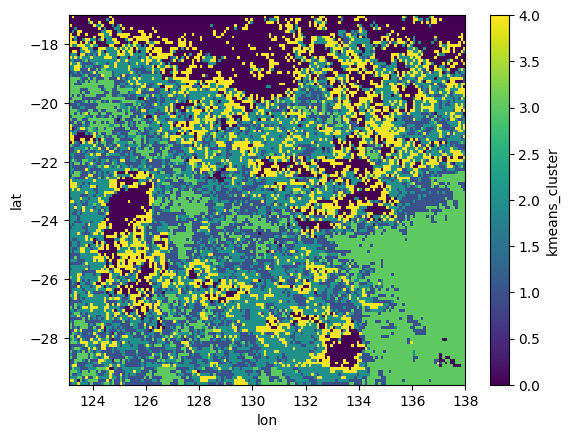

In [12]:
log.info("Starting tile-wise prediction...")
labels_2d = predict_on_tiles(ds_rf, model, tile_size=200)

if labels_2d is not None:
    labels_2d.name = "kmeans_cluster"
    log.info("Prediction complete. Plotting result...")
    labels_2d.plot.imshow()
else:
    log.error("Clustering failed: no valid output generated.")


In [15]:
log.info("Writing output to GeoTIFF...")
labels_2d = labels_2d.sortby("lat", ascending=False)
labels_2d.rio.set_spatial_dims(x_dim='lon', y_dim='lat')
labels_2d.rio.write_crs("EPSG:4326", inplace=True)
labels_2d.rio.to_raster("kmeans_clusters.tif")
log.info("GeoTIFF saved as kmeans_clusters.tif")

2025-08-06 13:27:43,592 - INFO - Writing output to GeoTIFF...
2025-08-06 13:27:43,692 - INFO - GeoTIFF saved as kmeans_clusters.tif


<xarray.DataArray 'kmeans_cluster' (lat: 126, lon: 149)> Size: 75kB
dask.array<getitem, shape=(126, 149), dtype=int32, chunksize=(31, 149), chunktype=numpy.ndarray>
Coordinates:
  * lat          (lat) float32 504B -17.05 -17.15 -17.25 ... -29.45 -29.55
  * lon          (lon) float32 596B 123.2 123.3 123.4 ... 137.8 137.9 138.0
    spatial_ref  int64 8B 0
